### Feature Selection

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

#### 1) Multi Class Classifcation

Load in the data and standardise it.

In [23]:
def load_data(bin=False):
    project_dir = os.path.dirname(os.path.abspath(''))
    df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
    X = df.loc[:, ~df.columns.isin(['Outcome', 'Outcome_Bin_H'])]
    if bin:
        y = df['Outcome_Bin_H']
    else:
        y = df['Outcome']
    return X, y
X, y = load_data(bin=False)

In [24]:
def prep_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prep_datasets(X, y)

Fit the baseline Logistic Regression model.

In [47]:
def log_reg_model(X_train, X_test, y_train, y_test):
    lgr = LogisticRegression()
    lgr.fit(X_train, y_train)
    y_pred_log = lgr.predict(X_test)
    accu_log = accuracy_score(y_test, y_pred_log) * 100
    print(f'Logistic Regression Model\nAccuracy: {accu_log:.2f}%.')
    return

log_reg_model(X_train, X_test, y_train, y_test)

Logistic Regression Model
Accuracy: 61.20%.


Look at feature heatmap to understand correlations between features better.

<AxesSubplot:>

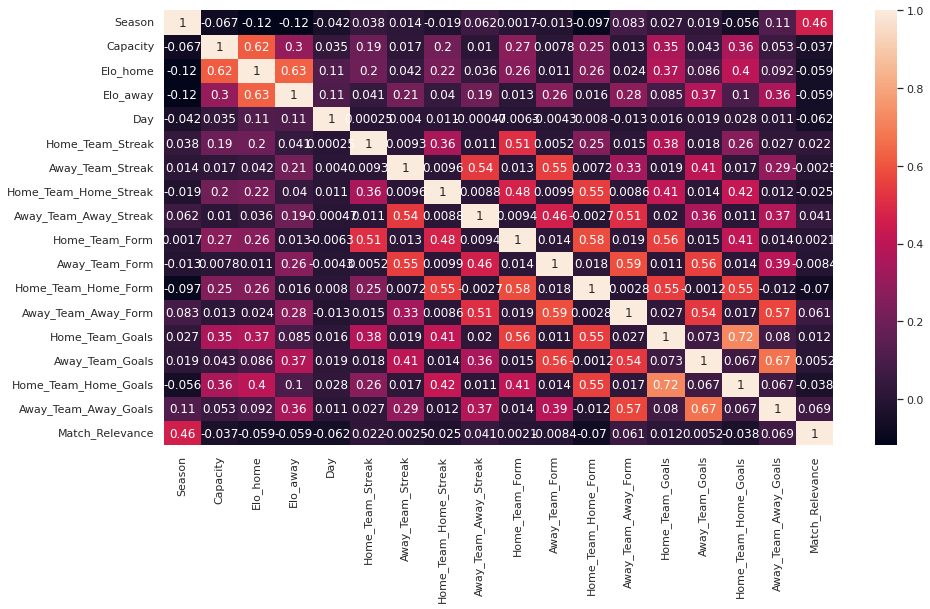

In [26]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr(), annot=True)

**Conclusion:**
From the above heatmap it is observed that the following are heavily correlated, and have a rational for doing so:

- Season and Match_Relevance
- Home_Team_Streak and Home_Team_Form
- Away_Team_Streak and Away_Team_Form
- Home_Team_Home_Streak and Home_Team_Streak and Home_Team_Form
- Away_Team_Away_Streak and Away_Team_Streak and Away_Team_Form
- Home_Team_Goals and Home_Team_Home_Goals
- Away_Team_Goals and Away_Team_Away_Goals

For simplicity, separation of H/A goals for H/A teams should be removed. Form is also very similar to streak and can be removed.
ELOs will be left as is because they are expected to be important to the model.

Lasso regression doesn't work well for multi class classification problems and so feature selection will need to be carried out for other model types.

#### 2) Binary Classifcation

In [45]:
X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
log_reg_model(X_train, X_test, y_train, y_test)

0.6098702960507183
Logistic Regression Model
Accuracy: 61.20%.


Carry out lasso regression to understand feature importance.

In [54]:
def lasso(X, X_train, y_train):
    alphas = [1, 0.1, 0.001]
    lasso_df = pd.DataFrame()
    lasso_df['Feature Name'] = list(X)
    for alpha in alphas:
        lasso = LogisticRegression(C=alpha, penalty='l1', solver='liblinear', random_state=42)
        lasso.fit(X_train, y_train)
        column_name = 'Alpha = %f' % alpha
        lasso_df[column_name] = lasso.coef_[0]
        lasso_df[column_name] = lasso_df[column_name].round(5)
    return lasso_df

lasso(X, X_train, y_train)

,Feature Name,Alpha = 1.000000,Alpha = 0.100000,Alpha = 0.001000
0,Season,-0.03225,-0.03180,0.00000
1,Capacity,0.07843,0.07826,0.06429
2,Elo_home,0.40647,0.40521,0.26584
3,Elo_away,-0.43942,-0.43784,-0.27722
4,Day,0.02885,0.02829,0.00000
5,Home_Team_Streak,0.03265,0.03226,0.00000
6,Away_Team_Streak,-0.03736,-0.03624,0.00000
7,Home_Team_Home_Streak,0.01493,0.01470,0.00000
8,Away_Team_Away_Streak,0.02345,0.02155,0.00000
9,Home_Team_Form,0.04844,0.04846,0.04818


From the above it is clear that the Day, Season, Streaks and Match Relevance are the least important features. These features are removed as well as those that are highly correlated to one another, or cannot be easily inferred for future fixtures, and the model is re-ran.

In [61]:
X, y = load_data(bin=True)
X = X.drop([
    'Day',
    'Season',
    'Home_Team_Streak',
    'Away_Team_Streak',
    'Home_Team_Home_Streak',
    'Away_Team_Away_Streak',
    'Match_Relevance',
    'Home_Team_Home_Form',
    'Away_Team_Away_Form',
    'Home_Team_Home_Goals',
    'Away_Team_Away_Goals'
    ], axis=1)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
log_reg_model(X_train, X_test, y_train, y_test)

Logistic Regression Model
Accuracy: 60.76%.


<AxesSubplot:>

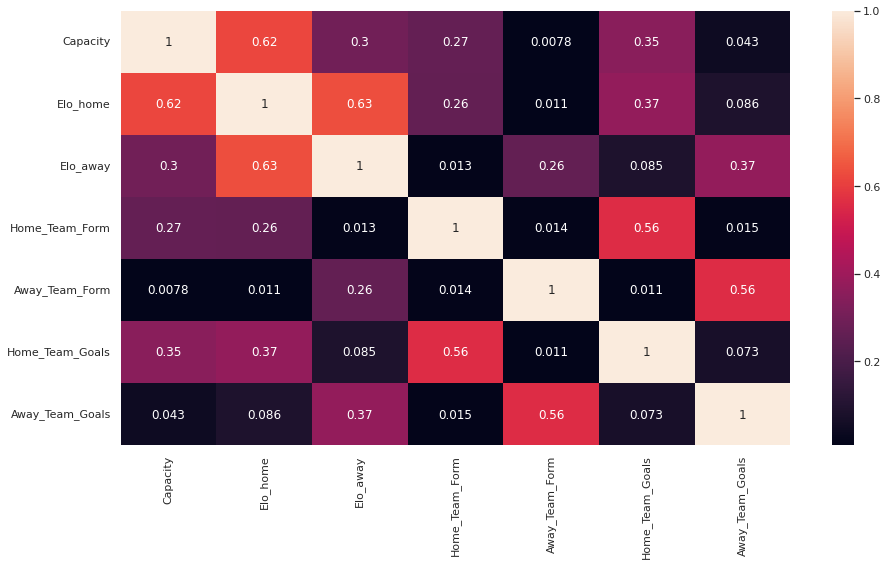

In [62]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr(), annot=True)